# Picking an Ambulance

Base on two criteria

- Closest ambulance - Based on shortest travel time
- Disruption - When I remove one ambulance, what is the resulting coverage and the difference? 

In [1]:
import read_data
import numpy as np
from matplotlib import pyplot as plt
import copy

# Data
(calls, allbases, demands, times, calls_latlong) = read_data.populate_data()
allbases = np.delete(np.array(allbases), 2, 1)
demands = np.delete(np.array(demands), 2, 1)
times = np.array(times)
calls_latlong = np.array(calls_latlong)

num_ambulances = 8

In [2]:
# Pasted from yesterday: choose bases using greedy
# Get the first base
times_copy = copy.deepcopy(times)


# Continually get the min cost row (most optimal base)
# Delete the columns that are covered by this base by r1
# Recalculate the total cost for each base
# Repeat

r1 = 600

numbases = 8
list_bases = []
total_covered = []
for x in range(numbases):
#     print("Ambulance Location #%d" %(x+1))
    print(np.shape(times_copy))
    covered = []
    row_num = 0
    for row in times_copy:
        count = 0
        for col in row:
            if col < r1:
                count += 1
#                 print(row_num, count, col, r1)
        covered.append((row_num, count))
        row_num += 1
    
    d = [('index', int), ('covered', int)]
    covered = np.array(covered, d)
    
    min_cost = (np.sort(covered, order='covered', kind='mergesort')[-1])
    #print((np.sort(covered, order='covered', kind='mergesort')))
#     print(min_cost)
#     print(times_copy[min_cost[0]])
    
    list_bases.append(min_cost[0])
    
    # Delete the columns (demands) that are covered by r1.
    
    primary_covered = [times_copy[min_cost[0]][i] < r1 for i in range(len(times_copy[min_cost[0]]))]
    #print(primary_covered)
    covered_indices = [i for i in range(len(primary_covered)) if primary_covered[i] ]
#     print("Covered: ", len(covered_indices), covered_indices)
    total_covered += covered_indices
    
    #times_copy = np.delete(times_copy, min_cost[0], axis=0)
    times_copy = np.delete(times_copy, covered_indices, axis=1)
#     print("\n")

ind = list_bases
print("Total Covered: " , len(total_covered))

(969, 100)
(969, 72)
(969, 54)
(969, 38)
(969, 26)
(969, 19)
(969, 15)
(969, 11)
Total Covered:  92


In [3]:
# ind = np.random.randint(0, allbases.shape[0], num_ambulances)
bases = allbases[ind,:]
points = np.delete(allbases, ind, 0)

chosen_base_costs = times[ind,:]

Need the travel time between the ambulance starting location and the case end location. 

- If ambulance is at base, and location can be using demand location, then do (base, location) --> (base, time)
- Else, query Google

In [4]:
# Randomly choose a demand point
call_location = np.random.randint(0, high=100)
call_location

90

In [5]:
# Fastest it can get there
current_travel_times = chosen_base_costs[:, call_location]
fastest = np.min(current_travel_times)
ambulance = -1

# Which ambulance to choose from chosen_base_costs? 
for amb in range(len(current_travel_times)):
    if fastest == current_travel_times[amb]:
        ambulance = amb
        break
ambulance, fastest, current_travel_times

(0,
 522.0,
 array([  522.,   585.,  1504.,  1049.,   930.,   946.,   652.,  1045.]))

In [6]:
def ind_to_set_of_ind_one_removed(chosen_base_costs):
    """ Returns the set of all sets of bases with one ambulance removed. """
    
    all_one_removed = []
    for i in range(len(chosen_base_costs)):
        all_one_removed.append(np.delete(chosen_base_costs, i, axis=0))
    return all_one_removed

In [7]:
all_one_removed = ind_to_set_of_ind_one_removed(chosen_base_costs)

In [8]:
def radius_to_coverage (chosen_costs, r1=600, graph=True):
    r1_coverage = np.any(chosen_costs < r1, 0)
    r1_covered = np.nonzero(r1_coverage)
    r1_exposed = np.nonzero(np.logical_not(r1_coverage))

    c = np.shape(r1_covered)[1]
    e = np.shape(r1_exposed)[1]
    ratio = (c / (c + e))
    

    if graph:
        plt.figure()
        plt.scatter(demands[r1_covered,0],demands[r1_covered,1], c='b')
        plt.scatter(demands[r1_exposed,0],demands[r1_exposed,1], c='r')
        plt.scatter(bases[:,0],bases[:,1], c='y')
        plt.show()
    
    return 100 * ratio

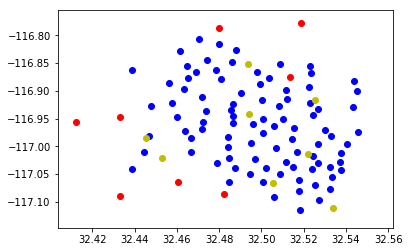

92.0

In [9]:
c = radius_to_coverage(chosen_base_costs)
c

In [10]:
for amb in range(0, num_ambulances):
    coverage = radius_to_coverage(all_one_removed[amb], graph=False)
    print ("Amb %2d. "% amb, 
           "Travel:  %4d. " % current_travel_times [amb],
           "Cover:  %2d. " % coverage, 
           "Disruption:  %2.1f. " % (c - coverage)
          )
print ("Fastest Time: %d" % fastest )

Amb  0.  Travel:   522.  Cover:  75.  Disruption:  17.0. 
Amb  1.  Travel:   585.  Cover:  76.  Disruption:  16.0. 
Amb  2.  Travel:  1504.  Cover:  76.  Disruption:  16.0. 
Amb  3.  Travel:  1049.  Cover:  89.  Disruption:  3.0. 
Amb  4.  Travel:   930.  Cover:  88.  Disruption:  4.0. 
Amb  5.  Travel:   946.  Cover:  88.  Disruption:  4.0. 
Amb  6.  Travel:   652.  Cover:  88.  Disruption:  4.0. 
Amb  7.  Travel:  1045.  Cover:  89.  Disruption:  3.0. 
Fastest Time: 522
